## Imports

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
import astropy.units as u
from gaussian_process import *


df = pd.read_csv('gp_objects(downsample).csv')
obj = sorted(df.obj_id.unique())
df_observed = pd.read_csv('gp_objects_original_observations(matched).csv')
df_observed = df_observed[df_observed.obj_id.isin(obj)]
display(df)
display(df_observed)
common_columns = ['obj_id', 'type', 'redshift', 'mjd', 'mjd_0', 't', 'mag_ztfg',
    'abs_mag_ztfg', 'mag_error_ztfg', 'mag_ztfr', 'abs_mag_ztfr',
    'mag_error_ztfr', 'mag_ztfi', 'abs_mag_ztfi', 'mag_error_ztfi',]
filters = ['ztfg', 'ztfr', 'ztfi']

,obj_id,type,redshift,mjd,mjd_0,t,mag_ztfg,abs_mag_ztfg,mag_error_ztfg,mag_ztfr,...,abs_mag_ztfi,mag_error_ztfi,flux_ztfg,flux_error_ztfg,flux_ztfr,flux_error_ztfr,flux_ztfi,flux_error_ztfi,rise,fade
0,ZTF18aakuewf,Ibn,0.0636,58226.340532,58226.340532,0.000000,18.516426,-13.834339,0.235213,18.914558,...,NaN,NaN,142.373588,30.843697,98.668109,1.246373,NaN,NaN,y,y
1,ZTF18aakuewf,Ibn,0.0636,58226.390513,58226.340532,0.049981,18.496472,-13.854294,0.224712,18.882957,...,NaN,NaN,145.014457,30.013242,101.582057,1.080243,NaN,NaN,y,y
2,ZTF18aakuewf,Ibn,0.0636,58226.440494,58226.340532,0.099961,18.476866,-13.873900,0.214622,18.852310,...,NaN,NaN,147.656847,29.187955,104.490322,1.080575,NaN,NaN,y,y
3,ZTF18aakuewf,Ibn,0.0636,58226.490474,58226.340532,0.149942,18.457598,-13.893168,0.204923,18.822692,...,NaN,NaN,150.300692,28.367979,107.379974,1.219787,NaN,NaN,y,y
4,ZTF18aakuewf,Ibn,0.0636,58226.540455,58226.340532,0.199923,18.438655,-13.912110,0.195597,18.794102,...,NaN,NaN,152.945927,27.553467,110.245034,1.433721,NaN,NaN,y,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36853,ZTF24aascytf,II,0.0380,60480.172223,60476.217836,3.954388,20.793887,-10.398977,1.026317,20.312205,...,-11.090834,0.700057,17.476125,16.519709,27.234410,15.860492,33.051259,21.310669,y,y
36854,ZTF24aascytf,II,0.0380,60480.181356,60476.217836,3.963520,20.795950,-10.396914,1.034748,20.315167,...,-11.087963,0.703241,17.442947,16.623801,27.160225,15.918773,32.963971,21.351059,y,y
36855,ZTF24aascytf,II,0.0380,60480.190488,60476.217836,3.972653,20.797930,-10.394934,1.043002,20.318076,...,-11.085116,0.706375,17.411165,16.725866,27.087546,15.974491,32.877653,21.390053,y,y
36856,ZTF24aascytf,II,0.0380,60480.199621,60476.217836,3.981785,20.799828,-10.393036,1.051076,20.320933,...,-11.082294,0.709458,17.380760,16.825905,27.016360,16.027639,32.792302,21.427639,y,y


,obj_id,type,redshift,mjd,mjd_0,t,mag_ztfg,abs_mag_ztfg,mag_error_ztfg,mag_ztfr,abs_mag_ztfr,mag_error_ztfr,mag_ztfi,abs_mag_ztfi,mag_error_ztfi
0,ZTF18aakuewf,Ibn,0.0636,58226.340532,58226.340532,0.000000,NaN,NaN,NaN,18.961000,-13.389765,0.031726,NaN,NaN,NaN
1,ZTF18aakuewf,Ibn,0.0636,58226.358623,58226.340532,0.018090,NaN,NaN,NaN,18.871901,-13.478865,0.029414,NaN,NaN,NaN
2,ZTF18aakuewf,Ibn,0.0636,58226.378947,58226.340532,0.038414,NaN,NaN,NaN,18.922800,-13.427966,0.033493,NaN,NaN,NaN
3,ZTF18aakuewf,Ibn,0.0636,58226.414456,58226.340532,0.073924,NaN,NaN,NaN,18.856501,-13.494265,0.031619,NaN,NaN,NaN
4,ZTF18aakuewf,Ibn,0.0636,58226.415394,58226.340532,0.074861,NaN,NaN,NaN,18.849501,-13.501265,0.033379,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5849,ZTF24aascytf,II,0.038,60479.408218,60476.217836,3.190382,20.327264,-10.8656,0.156657,NaN,NaN,NaN,NaN,NaN,NaN
5850,ZTF24aascytf,II,0.038,60481.354132,60476.217836,5.136296,NaN,NaN,NaN,20.379625,-10.813239,0.187584,NaN,NaN,NaN
5851,ZTF24aascytf,II,0.038,60485.341238,60476.217836,9.123403,NaN,NaN,NaN,20.009301,-11.183563,0.197632,NaN,NaN,NaN
5852,ZTF24aascytf,II,0.038,60485.341238,60476.217836,9.123403,NaN,NaN,NaN,20.009281,-11.183583,0.197632,NaN,NaN,NaN


In [2]:
len(df.obj_id.unique())

69

In [3]:
df_rates = pd.DataFrame()
df_rates['obj_id'] = df.obj_id.unique()

In [4]:
display(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].describe())
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.85))
print()
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.95))
print()
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.99))

,mag_error_ztfg,mag_error_ztfr,mag_error_ztfi
count,35858.000000,36858.000000,12666.000000
mean,0.793342,0.236673,0.318264
std,94.216836,6.605015,3.191100
min,-550.584905,-355.417462,-312.833650
25%,0.066958,0.064859,0.118401
50%,0.131489,0.115213,0.220913
75%,0.322449,0.199798,0.384880
max,17819.057202,1121.578539,116.527049


mag_error_ztfg    0.471433
mag_error_ztfr    0.299639
mag_error_ztfi    0.496280
Name: 0.85, dtype: float64

mag_error_ztfg    1.113346
mag_error_ztfr    0.592006
mag_error_ztfi    0.902958
Name: 0.95, dtype: float64

mag_error_ztfg    3.859880
mag_error_ztfr    1.987332
mag_error_ztfi    2.061218
Name: 0.99, dtype: float64


Filtering out the high error data/data that has errors that don't make sense

In [5]:
for item in ['ztfg','ztfr','ztfi']:
    df.loc[df[f'mag_error_{item}'] < 0, f'mag_error_{item}'] = np.nan
    df.loc[df[f'mag_error_{item}'] > 1, f'mag_error_{item}'] = np.nan

In [6]:
display(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].describe())
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.85))
print()
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.95))
print()
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.99))

,mag_error_ztfg,mag_error_ztfr,mag_error_ztfi
count,33693.000000,35955.000000,12118.000000
mean,0.196441,0.157239,0.262382
std,0.184862,0.145742,0.188799
min,0.006668,0.007899,0.014755
25%,0.065530,0.064031,0.117288
50%,0.122143,0.113161,0.207859
75%,0.275271,0.193089,0.363074
max,0.999976,0.999657,0.999118


mag_error_ztfg    0.384540
mag_error_ztfr    0.262506
mag_error_ztfi    0.448756
Name: 0.85, dtype: float64

mag_error_ztfg    0.591690
mag_error_ztfr    0.486509
mag_error_ztfi    0.658974
Name: 0.95, dtype: float64

mag_error_ztfg    0.845385
mag_error_ztfr    0.688026
mag_error_ztfi    0.885056
Name: 0.99, dtype: float64


In [7]:
# for obj_i in obj:
#     # print(obj_i)
#     df_obj = df[df.obj_id == obj_i]
#     fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#     for filter in ['ztfg', 'ztfr', 'ztfi']:
#         # df_det = df_observed[(df_observed.obj_id == obj_i) & (df_observed.filter == filter) & (df_observed.t < df_obj.t.max())]
#         ax.fill_between(df_obj.t, df_obj[f'abs_mag_{filter}'] - df_obj[f'mag_error_{filter}'], df_obj[f'abs_mag_{filter}'] + df_obj[f'mag_error_{filter}'], alpha=0.3)
#         ax.plot(df_obj.t, df_obj[f'abs_mag_{filter}'], label=filter)
#         # ax.scatter(df_det.t, df_det.absmag, c='r', s=100)
#     ax.invert_yaxis()
#     ax.legend()
#     obj_id = df_obj['obj_id'].iloc[0]
#     obj_type = df_obj['type'].iloc[0]
#     ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_type}')
#     plt.show()

## Rate Calculations

In [48]:
def calc_peak(df, abs=True, filters=['ztfg','ztfr','ztfi']):
    '''
    Calculates the peak magntitude in a given set of filters and returns them as a dictionary containing the time and value
    
    Args:
    df: dataframe
    abs: use absolute magnitude
    filters: list of filters to search for. Default behavior searches for all ztf filters. Function will not fail if the dataframe does not contain that filter
    
    Returns
    peak_dict: dictionary of peak values/times with filters as keys. Order is (t,value)
    '''
    peak_dict = {filter: (np.nan,np.nan) for filter in filters}
    for filt in filters:
        if abs:
            mag = 'abs_mag_' + filt
        else:
            mag = 'mag_' + filt
        
        if mag in df.columns:
            peak = df[df[mag] == df[mag].min()]
            if len(peak) > 0:
                peak = peak.iloc[0]
                peak_dict[filt] = (peak['t'], peak[mag])
                
    return peak_dict

def calc_fwhm(df, abs=True, filters=['ztfg','ztfr','ztfi'], mag_diff=-2.5*np.log10(0.5), extrapolate=True):
    '''
    Calculates the full width at half maximum in a given set of filters and returns them as a dictionary containing the time duration and value
    
    Args:
    df: dataframe
    abs: use absolute magnitude
    filters: list of filters to search for. Default behavior searches for all ztf filters. Function will not fail if the dataframe does not contain that filter
    mag_diff: the difference in magnitude between the peak and the half maximum value. Default is -2.5*np.log10(0.5) (corresponds to half the flux)
    extrapolate (bool): whether to extrapolate the fwhm value if there is not both a rise and fade in the data. If set to true and, for example, there is only a fade, the function will extrapolate the fwhm value by assuming the rise time is equal to the fade time
    
    Returns
    fwhm_dict: dictionary of fwhm duration with filters as keys.
    rise_hwhm_dict: dictionary of duration of time above half maximum before the peak with filters as keys.
    fade_hwhm_dict: dictionary of duration of time above half maximum after the peak with filters as keys.
    fade_hwhm_dict: dictionary of peak times with filters as keys.
    '''
    fwhm_dict = {filter: np.nan for filter in filters}
    rise_hwhm_dict = {filter: np.nan for filter in filters}
    fade_hwhm_dict = {filter: np.nan for filter in filters}
    peak_dict = calc_peak(df, abs=abs, filters=filters)
    
    for filter_ in filters:
        if abs:
            mag = 'abs_mag_' + filter_
        else:
            mag = 'mag_' + filter_
        
        if mag in df.columns:
            peak = peak_dict[filter_]
            if peak[0] is not np.nan:
                half_peak = peak[1] + mag_diff
                df_filter = df[df[mag].notnull()]
                df_rise = df_filter[df_filter['t'] <= peak[0]]
                df_fade = df_filter[df_filter['t'] >= peak[0]]
                if len(df_rise) > 0:
                    rise = df_rise[df_rise[mag] < half_peak]
                    rise_fwhm_time = peak[0] - rise.iloc[0]['t']
                    rise_hwhm_dict[filter_] = rise_fwhm_time
                if len(df_fade) > 0:
                    fade = df_fade[df_fade[mag] < half_peak]
                    fade_fwhm_time = fade.iloc[-1]['t'] - peak[0]
                    fade_hwhm_dict[filter_] = fade_fwhm_time
                if len(df_rise) > 0 and len(df_fade) > 0:
                    fwhm_dict[filter_] = rise_fwhm_time + fade_fwhm_time
                elif extrapolate:
                    if len(df_rise) == 0 and len(df_fade) == 0:
                        fwhm_dict[filter_] = np.nan
                    elif len(df_rise) == 0:
                        fwhm_dict[filter_] = fade_fwhm_time * 2
                    elif len(df_fade) == 0:
                        fwhm_dict[filter_] = rise_fwhm_time * 2
    ## set any values that are 0 to be np.nan
    for filter_ in filters:
        if fwhm_dict[filter_] == 0:
            fwhm_dict[filter_] = np.nan
        if rise_hwhm_dict[filter_] == 0:
            rise_hwhm_dict[filter_] = np.nan
        if fade_hwhm_dict[filter_] == 0:
            fade_hwhm_dict[filter_] = np.nan
    
    return fwhm_dict, rise_hwhm_dict, fade_hwhm_dict


def calc_min(df, abs=True, filters=['ztfg','ztfr','ztfi']):
    '''
    Calculates the minimum magntitude in a given set of filters and returns them as a dictionary containing the time and value
    
    Args:
    df: dataframe
    abs: use absolute magnitude
    filters: list of filters to search for. Default behavior searches for all ztf filters. Function will not fail if the dataframe does not contain that filter
    
    Returns
    min_dict: dictionary of min values/times with filters as keys. Order is (t,value)
    '''
    min_dict = {filter: (np.nan,np.nan) for filter in filters}
    for filt in filters:
        if abs:
            mag = 'abs_mag_' + filt
        else:
            mag = 'mag_' + filt
        
        if mag in df.columns:
            min = df[df[mag] == df[mag].max()]
            if len(min) > 0:
                min = min.iloc[0]
                min_dict[filt] = (min['t'], min[mag])
                
    return min_dict

def calc_rate(df, interval_dict, abs=True, filters=['ztfg','ztfr','ztfi']):
    '''
    Calculates the rate of change in a given set of filters and returns them as a dictionary containing the time duration and value
    
    Args:
    df: dataframe
    interval_dict: time interval to calculate rate of change for each filter
    abs: use absolute magnitude
    filters: list of filters to search for. Default behavior searches for all ztf filters. Function will not fail if the dataframe does not contain that filter
    
    Returns
    rate_dict: dictionary of rate values/times with filters as keys. Order is (t,value)
    '''
    rate_dict = {filter: (np.nan,np.nan) for filter in filters}
    for filt in filters:
        interval = interval_dict[filt]
        if abs:
            mag = 'abs_mag_' + filt
        else:
            mag = 'mag_' + filt
        
        if mag in df.columns:
            df_filter = df[df[mag].notnull()]
            df_rate = df_filter[(df_filter['t'] >= interval[0]) & (df_filter['t'] <= interval[1])]
            time_interval = df_rate['t'].max() - df_rate['t'].min()
            if time_interval > 0:
                mag_interval = df_rate.iloc[-1][mag] - df_rate.iloc[0][mag] 
                # print(mag_interval)
                # mag_interval = df_rate[mag].loc[df_rate['t'].idxmax()] - df_rate[mag].loc[df_rate['t'].idxmin()]
                rate_dict[filt] = (time_interval, mag_interval/time_interval)
    
    return rate_dict
            

In [49]:
# # Iterate over each object in the dataframe
# for obj_i in obj:
#     df_obj = df[df.obj_id == obj_i]
#     min_dict = calc_peak(df_obj)
    
#     fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#     for filter in filters:
#         ax.fill_between(df_obj.t, df_obj[f'abs_mag_{filter}'] - df_obj[f'mag_error_{filter}'], df_obj[f'abs_mag_{filter}'] + df_obj[f'mag_error_{filter}'], alpha=0.3)
#         ax.plot(df_obj.t, df_obj[f'abs_mag_{filter}'], label=filter)
        
#         # Plot vertical lines at min magnitudes
#         min_time, min_mag = min_dict[filter]
#         if min_time is not None:
#             ax.axvline(x=min_time, color='r', linestyle='--')
#             ax.text(min_time, min_mag, f'{filter} min', rotation=90, verticalalignment='bottom')
    
#     ax.invert_yaxis()
#     ax.legend()
#     obj_id = df_obj['obj_id'].iloc[0]
#     obj_type = df_obj['type'].iloc[0]
#     ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_type}')
#     plt.show()

#### Peak Values

In [50]:
df_rise = df[df.rise == 'y']

## identify the times of the peak in each filter for each object
df_peak = df.groupby('obj_id').apply(calc_peak)
df_peak = pd.DataFrame(df_peak.to_list(), index=df_peak.index)
df_peak = df_peak.reset_index()

for filt in ['ztfg', 'ztfr', 'ztfi']:
    df_peak[f'{filt}_peak_time'] = df_peak[f'{filt}'].apply(lambda x: x[0])
    df_peak[f'{filt}_peak_mag'] = df_peak[f'{filt}'].apply(lambda x: x[1])

    df_peak.drop(columns=[f'{filt}'], inplace=True)
df_peak


,obj_id,ztfg_peak_time,ztfg_peak_mag,ztfr_peak_time,ztfr_peak_mag,ztfi_peak_time,ztfi_peak_mag
0,ZTF18aakuewf,3.898491,-14.661857,4.198375,-14.544391,NaN,NaN
1,ZTF18aalrxas,1.961364,-13.241093,2.059432,-12.955816,NaN,NaN
2,ZTF18abffyqp,0.950871,-12.541572,2.502293,-12.327379,NaN,NaN
3,ZTF18abvkmgw,4.277578,-12.382398,4.730358,-12.389784,NaN,NaN
4,ZTF18abwkrbl,2.837926,-12.291909,3.620802,-12.221934,NaN,NaN
...,...,...,...,...,...,...,...
64,ZTF23abnpdod,2.001440,14.101237,1.951404,14.258993,1.901368,14.533615
65,ZTF23abobwsd,0.000000,-12.108568,0.000000,-12.180304,0.000000,-12.100538
66,ZTF23absbqun,1.853466,-9.354963,1.846337,-10.071233,NaN,NaN
67,ZTF23abtycgb,0.000000,-10.654520,0.000000,-10.700839,NaN,NaN


Color at ztfg peak

In [51]:
df_ztfg_peak_color = pd.DataFrame()
df_ztfg_peak_color['obj_id'] = df_peak.obj_id.unique()
ztfg_peak_color_dict = {}
for obj in df_ztfg_peak_color['obj_id']:
    obj_ztfg_peak_color_dict = {}
    df_obj = df_peak[df_peak.obj_id == obj]
    ztfg_peak_time = df_obj['ztfg_peak_time'].iloc[0]
    if ztfg_peak_time != None and ztfg_peak_time == ztfg_peak_time:
        ztfg_peak_row = df[(df.obj_id == obj) & (df.t == ztfg_peak_time)]
        for filt in ['ztfr', 'ztfi']:
            if ztfg_peak_row[f'abs_mag_ztfg'].iloc[0] == np.nan or ztfg_peak_row[f'abs_mag_{filt}'].iloc[0] == np.nan:
                obj_ztfg_peak_color_dict[filt] = np.nan
            else:
                obj_ztfg_peak_color_dict[filt] = ztfg_peak_row[f'abs_mag_ztfg'].iloc[0] - ztfg_peak_row[f'abs_mag_{filt}'].iloc[0]
    else:
        for filt in ['ztfr', 'ztfi']:
            obj_ztfg_peak_color_dict[filt] = np.nan
    ztfg_peak_color_dict[obj] = obj_ztfg_peak_color_dict     

In [52]:
df_ztfg_peak_color = pd.DataFrame(ztfg_peak_color_dict).T.rename(columns={'ztfr': 'ztfg_peak_gr_color', 'ztfi': 'ztfg_peak_gi_color'}).reset_index()
df_ztfg_peak_color['obj_id'] = df_ztfg_peak_color['index']
df_ztfg_peak_color.drop(columns=['index'], inplace=True)

df_ztfg_peak_color

,ztfg_peak_gr_color,ztfg_peak_gi_color,obj_id
0,-0.125221,NaN,ZTF18aakuewf
1,-0.285940,NaN,ZTF18aalrxas
2,-0.266498,NaN,ZTF18abffyqp
3,-0.003031,NaN,ZTF18abvkmgw
4,-0.092534,NaN,ZTF18abwkrbl
...,...,...,...
64,-0.158754,-0.435016,ZTF23abnpdod
65,0.071736,-0.008030,ZTF23abobwsd
66,0.716266,NaN,ZTF23absbqun
67,0.046319,NaN,ZTF23abtycgb


Color at ztfr peak

In [53]:
df_ztfr_peak_color = pd.DataFrame()
df_ztfr_peak_color['obj_id'] = df_peak.obj_id.unique()
ztfr_peak_color_dict = {}
for obj in df_ztfr_peak_color['obj_id']:
    obj_ztfr_peak_color_dict = {}
    df_obj = df_peak[df_peak.obj_id == obj]
    ztfr_peak_time = df_obj['ztfr_peak_time'].iloc[0]
    if ztfr_peak_time != None and ztfr_peak_time == ztfr_peak_time:
        ztfr_peak_row = df[(df.obj_id == obj) & (df.t == ztfr_peak_time)]
        for filt in ['ztfg', 'ztfi']:
            if ztfr_peak_row[f'abs_mag_ztfr'].iloc[0] == np.nan or ztfr_peak_row[f'abs_mag_{filt}'].iloc[0] == np.nan:
                obj_ztfr_peak_color_dict[filt] = np.nan
            else: ## note that this will be the r-g color and not the g-r color; if comparing the g-r color at the g peak vs the r peak, will need to multiply the rg color by -1
                obj_ztfr_peak_color_dict[filt] = ztfr_peak_row[f'abs_mag_ztfr'].iloc[0] - ztfr_peak_row[f'abs_mag_{filt}'].iloc[0]
    else:
        for filt in ['ztfg', 'ztfi']:
            obj_ztfr_peak_color_dict[filt] = np.nan
    ztfr_peak_color_dict[obj] = obj_ztfr_peak_color_dict     

In [54]:
df_ztfr_peak_color = pd.DataFrame(ztfr_peak_color_dict).T.rename(columns={'ztfg': 'ztfr_peak_rg_color', 'ztfi': 'ztfr_peak_ri_color'}).reset_index()
df_ztfr_peak_color['obj_id'] = df_ztfr_peak_color['index']
df_ztfr_peak_color.drop(columns=['index'], inplace=True)

df_ztfr_peak_color

,ztfr_peak_rg_color,ztfr_peak_ri_color,obj_id
0,0.114833,NaN,ZTF18aakuewf
1,0.281758,NaN,ZTF18aalrxas
2,0.142349,NaN,ZTF18abffyqp
3,-0.018309,NaN,ZTF18abvkmgw
4,0.041934,NaN,ZTF18abwkrbl
...,...,...,...
64,0.156243,-0.275028,ZTF23abnpdod
65,-0.071736,-0.079765,ZTF23abobwsd
66,-0.716282,NaN,ZTF23absbqun
67,-0.046319,NaN,ZTF23abtycgb


Color at ztfi peak

In [55]:
df_ztfi_peak_color = pd.DataFrame()
df_ztfi_peak_color['obj_id'] = df_peak.obj_id.unique()
ztfi_peak_color_dict = {}
for obj in df_ztfi_peak_color['obj_id']:
    obj_ztfi_peak_color_dict = {}
    df_obj = df_peak[df_peak.obj_id == obj]
    ztfi_peak_time = df_obj['ztfi_peak_time'].iloc[0]
    if ztfi_peak_time != None and ztfi_peak_time == ztfi_peak_time:
        ztfi_peak_row = df[(df.obj_id == obj) & (df.t == ztfi_peak_time)]
        for filt in ['ztfg', 'ztfr']:
            if ztfi_peak_row[f'abs_mag_ztfi'].iloc[0] == np.nan or ztfi_peak_row[f'abs_mag_{filt}'].iloc[0] == np.nan:
                obj_ztfi_peak_color_dict[filt] = np.nan
            else: ## note that this will be the r-g color and not the g-r color; if comparing the g-r color at the g peak vs the r peak, will need to multiply the rg color by -1
                obj_ztfi_peak_color_dict[filt] = ztfi_peak_row[f'abs_mag_ztfi'].iloc[0] - ztfi_peak_row[f'abs_mag_{filt}'].iloc[0]
    else:
        for filt in ['ztfg', 'ztfr']:
            obj_ztfi_peak_color_dict[filt] = np.nan
    ztfi_peak_color_dict[obj] = obj_ztfi_peak_color_dict     

In [56]:
df_ztfi_peak_color = pd.DataFrame(ztfi_peak_color_dict).T.rename(columns={'ztfg': 'ztfi_peak_ig_color', 'ztfr': 'ztfi_peak_ir_color'}).reset_index()
df_ztfi_peak_color['obj_id'] = df_ztfi_peak_color['index']
df_ztfi_peak_color.drop(columns=['index'], inplace=True)

df_ztfi_peak_color

,ztfi_peak_ig_color,ztfi_peak_ir_color,obj_id
0,NaN,NaN,ZTF18aakuewf
1,NaN,NaN,ZTF18aalrxas
2,NaN,NaN,ZTF18abffyqp
3,NaN,NaN,ZTF18abvkmgw
4,NaN,NaN,ZTF18abwkrbl
...,...,...,...
64,0.426735,0.273333,ZTF23abnpdod
65,0.008030,0.079765,ZTF23abobwsd
66,NaN,NaN,ZTF23absbqun
67,NaN,NaN,ZTF23abtycgb


In [57]:
df_color = pd.merge(df_ztfg_peak_color, df_ztfr_peak_color, on='obj_id')
df_color = pd.merge(df_color, df_ztfi_peak_color, on='obj_id')
df_color

,ztfg_peak_gr_color,ztfg_peak_gi_color,obj_id,ztfr_peak_rg_color,ztfr_peak_ri_color,ztfi_peak_ig_color,ztfi_peak_ir_color
0,-0.125221,NaN,ZTF18aakuewf,0.114833,NaN,NaN,NaN
1,-0.285940,NaN,ZTF18aalrxas,0.281758,NaN,NaN,NaN
2,-0.266498,NaN,ZTF18abffyqp,0.142349,NaN,NaN,NaN
3,-0.003031,NaN,ZTF18abvkmgw,-0.018309,NaN,NaN,NaN
4,-0.092534,NaN,ZTF18abwkrbl,0.041934,NaN,NaN,NaN
...,...,...,...,...,...,...,...
64,-0.158754,-0.435016,ZTF23abnpdod,0.156243,-0.275028,0.426735,0.273333
65,0.071736,-0.008030,ZTF23abobwsd,-0.071736,-0.079765,0.008030,0.079765
66,0.716266,NaN,ZTF23absbqun,-0.716282,NaN,NaN,NaN
67,0.046319,NaN,ZTF23abtycgb,-0.046319,NaN,NaN,NaN


#### Full-Width at Half-Max

In [58]:
fwhm_dict = {}
rise_hwhm_dict = {}
fade_hwhm_dict = {}
for obj in df.obj_id.unique():
    df_obj = df[df.obj_id == obj]
    fwhm_dict[obj], rise_hwhm_dict[obj], fade_hwhm_dict[obj] = calc_fwhm(df_obj)

In [59]:
df_fwhm = pd.DataFrame(fwhm_dict).T.rename(columns={'ztfg': 'ztfg_fwhm', 'ztfr': 'ztfr_fwhm', 'ztfi': 'ztfi_fwhm'}).reset_index()
df_rise_hwhm = pd.DataFrame(rise_hwhm_dict).T.rename(columns={'ztfg': 'ztfg_rise_hwhm', 'ztfr': 'ztfr_rise_hwhm', 'ztfi': 'ztfi_rise_hwhm'}).reset_index()
df_fade_hwhm = pd.DataFrame(fade_hwhm_dict).T.rename(columns={'ztfg': 'ztfg_fade_hwhm', 'ztfr': 'ztfr_fade_hwhm', 'ztfi': 'ztfi_fade_hwhm'}).reset_index()
df_fwhm = pd.merge(df_fwhm, df_rise_hwhm, on='index')
df_fwhm = pd.merge(df_fwhm, df_fade_hwhm, on='index')
df_fwhm['obj_id'] = df_fwhm['index']
df_fwhm.drop(columns=['index'], inplace=True)
df_fwhm

,ztfg_fwhm,ztfr_fwhm,ztfi_fwhm,ztfg_rise_hwhm,ztfr_rise_hwhm,ztfi_rise_hwhm,ztfg_fade_hwhm,ztfr_fade_hwhm,ztfi_fade_hwhm,obj_id
0,9.546305,9.296401,NaN,3.698568,3.498646,NaN,5.847736,5.797756,NaN,ZTF18aakuewf
1,4.560171,6.619602,NaN,1.961364,2.059432,NaN,2.598807,4.560171,NaN,ZTF18aalrxas
2,6.606055,9.959128,NaN,0.950871,2.502293,NaN,5.655183,7.456834,NaN,ZTF18abffyqp
3,9.794344,10.473514,NaN,3.014561,3.300527,NaN,6.779783,7.172987,NaN,ZTF18abvkmgw
4,7.437322,9.883810,NaN,2.152909,2.837926,NaN,5.284413,7.045884,NaN,ZTF18abwkrbl
...,...,...,...,...,...,...,...,...,...,...
64,3.902808,3.552556,4.002880,1.300936,1.300936,1.401008,2.601872,2.251620,2.601872,ZTF23abnpdod
65,6.348236,7.958295,7.958295,NaN,NaN,NaN,6.348236,7.958295,7.958295,ZTF23abobwsd
66,4.220199,5.118417,NaN,1.853466,1.846337,NaN,2.366733,3.272080,NaN,ZTF23absbqun
67,1.086289,1.752079,NaN,NaN,NaN,NaN,1.086289,1.752079,NaN,ZTF23abtycgb


#### Rise Rates

In [61]:
riserate_dict = {}
for obj_i in df_rise.obj_id.unique():
    df_obj = df_rise[df_rise.obj_id == obj_i]
    peak_dict = calc_peak(df_obj)
    
    ## cut off the light curve past the peak time for each filter
    for filter in filters:
        min_time, min_mag = peak_dict[filter]
        if min_time is not None:
            df_obj.loc[df_obj.t > min_time, f'abs_mag_{filter}'] = np.nan
            df_obj.loc[df_obj.t > min_time, f'mag_error_{filter}'] = np.nan
    interval_dict = {filter: (df_obj.t.min(), peak_dict[filter][0]) for filter in filters}
    rate_dict = calc_rate(df_obj, interval_dict)
    riserate_dict[obj_i] = rate_dict

In [62]:
df_riserate = pd.DataFrame(riserate_dict).T.rename(columns={'ztfg': 'ztfg_rise', 'ztfr': 'ztfr_rise', 'ztfi': 'ztfi_rise'}).reset_index()
df_riserate['obj_id'] = df_riserate['index']
df_riserate.drop(columns=['index'], inplace=True)

for filt in ['ztfg', 'ztfr', 'ztfi']:
    df_riserate[f'{filt}_rise_duration'] = df_riserate[f'{filt}_rise'].apply(lambda x: x[0])
    df_riserate[f'{filt}_rise_rate'] = df_riserate[f'{filt}_rise'].apply(lambda x: x[1])
    df_riserate.drop(columns=[f'{filt}_rise'], inplace=True)


df_riserate

,obj_id,ztfg_rise_duration,ztfg_rise_rate,ztfr_rise_duration,ztfr_rise_rate,ztfi_rise_duration,ztfi_rise_rate
0,ZTF18aakuewf,3.898491,-0.212266,4.198375,-0.263955,NaN,NaN
1,ZTF18aalrxas,1.961364,-0.347913,2.059432,-0.255482,NaN,NaN
2,ZTF18abffyqp,0.950871,-0.022003,2.502293,-0.051005,NaN,NaN
3,ZTF18abvkmgw,4.277578,-0.375830,4.730358,-0.339628,NaN,NaN
4,ZTF18abwkrbl,2.837926,-0.682061,3.620802,-0.485527,NaN,NaN
5,ZTF19aapfmki,3.675950,-0.087083,3.994339,-0.063915,NaN,NaN
6,ZTF19aatesgp,6.605405,-0.661647,5.504504,-0.369039,6.104995,-0.099476
7,ZTF19abxtcio,13.868424,-0.036465,15.104224,-0.071414,NaN,NaN
8,ZTF19abyjzvd,2.963563,-0.043346,3.454153,-0.035751,NaN,NaN
9,ZTF19acbumks,3.267955,-0.175060,3.340577,-0.191421,NaN,NaN


In [63]:
df_riserate['ztfg_rise_duration'].describe()

count    33.000000
mean      5.987460
std       6.415187
min       0.244034
25%       1.503009
50%       2.963563
75%       8.959310
max      22.508858
Name: ztfg_rise_duration, dtype: float64

#### Fade Rates

In [64]:
len(df[df.rise == 'n'][df.fade== 'y'].obj_id.unique())

/tmp/ipykernel_1392076/2926404735.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df[df.rise == 'n'][df.fade== 'y'].obj_id.unique())


36

In [65]:
df_fade = df[df.fade == 'y']
rise_and_fade_objects = df[(df.rise =='y') & (df.fade == 'y')].obj_id.unique()

faderate_dict = {}
for obj_i in df_fade.obj_id.unique():
    df_obj = df_fade[df_fade.obj_id == obj_i]
    peak_dict = calc_peak(df_obj)
    interval_dict = {}
    for filt in ['ztfg', 'ztfr', 'ztfi']:
        min_time, min_mag = peak_dict[filt]
        if min_time is not None:
            start_time, end_time = min_time, min_time+2 ## calculating fade rate between the peak and 2 days after the peak
            interval_dict[filt] = (start_time, end_time)
        else:
            interval_dict[filt] = (np.nan, np.nan)
    #interval_dict = {filter: (peak_dict[filter][0], peak_dict[filter][0]+2) for filter in filters}
    
    if obj_i == 'ZTF21aaabrpu': ## this one is weird about the peak time, and the ztfg is rising while the other two are falling
        ztfr_first_datapoint = df_obj[df_obj.abs_mag_ztfr.notnull()].iloc[0]
        ztfr_first_datapoint_mag = ztfr_first_datapoint.abs_mag_ztfr
        ztfr_first_datapoint_time = ztfr_first_datapoint.t
        ztfi_first_datapoint = df_obj[df_obj.abs_mag_ztfi.notnull()].iloc[0]
        ztfi_first_datapoint_mag = ztfi_first_datapoint.abs_mag_ztfi
        ztfi_first_datapoint_time = ztfi_first_datapoint.t
        interval_dict = {'ztfg':(np.nan,np.nan), 
                         'ztfr':(ztfr_first_datapoint_time, ztfr_first_datapoint_time+2), 
                         'ztfi':(ztfi_first_datapoint_time, ztfi_first_datapoint_time+2)}
    rate_dict = calc_rate(df_obj, interval_dict)
    faderate_dict[obj_i] = rate_dict


In [66]:
df_faderate = pd.DataFrame(faderate_dict).T.rename(columns={'ztfg': 'ztfg_fade', 'ztfr': 'ztfr_fade', 'ztfi': 'ztfi_fade'})
df_faderate.reset_index(inplace=True)
df_faderate['obj_id'] = df_faderate['index']
df_faderate.drop(columns=['index'], inplace=True)
for filt in ['ztfg', 'ztfr', 'ztfi']:
    df_faderate[f'{filt}_fade_duration'] = df_faderate[f'{filt}_fade'].apply(lambda x: x[0])
    df_faderate[f'{filt}_fade_rate'] = df_faderate[f'{filt}_fade'].apply(lambda x: x[1])
    df_faderate.drop(columns=[f'{filt}_fade'], inplace=True)
df_faderate

,obj_id,ztfg_fade_duration,ztfg_fade_rate,ztfr_fade_duration,ztfr_fade_rate,ztfi_fade_duration,ztfi_fade_rate
0,ZTF18aakuewf,1.999226,0.049672,1.999226,0.090028,NaN,NaN
1,ZTF18aalrxas,1.961364,0.269657,1.961364,0.136355,NaN,NaN
2,ZTF18abffyqp,1.951789,0.057277,1.951789,0.041661,NaN,NaN
3,ZTF18abvkmgw,1.989848,0.074062,1.989848,0.042339,NaN,NaN
4,ZTF18abwkrbl,1.957190,0.073346,1.957190,0.059018,NaN,NaN
...,...,...,...,...,...,...,...
61,ZTF23abnpdod,1.951404,0.302044,1.951404,0.349539,1.951404,0.315379
62,ZTF23abobwsd,1.978073,0.112160,1.978073,0.061998,1.978073,0.019844
63,ZTF23absbqun,1.996040,0.270486,1.996040,0.144054,NaN,NaN
64,ZTF23abtycgb,1.997370,0.610436,1.997370,0.424219,NaN,NaN


In [67]:
df_fade = df[df.fade == 'y']
rise_and_fade_objects = df[(df.rise =='y') & (df.fade == 'y')].obj_id.unique()

faderate_dict = {}
for obj_i in df_fade.obj_id.unique():
    df_obj = df_fade[df_fade.obj_id == obj_i]
    peak_dict = calc_peak(df_obj)
    interval_dict = {}
    for filt in ['ztfg', 'ztfr', 'ztfi']:
        min_time, min_mag = peak_dict[filt]
        if min_time is not None:
            start_time, end_time = min_time, min_time+2
            interval_dict[filt] = (start_time, end_time)
        else:
            interval_dict[filt] = (np.nan, np.nan)
    #interval_dict = {filter: (peak_dict[filter][0], peak_dict[filter][0]+2) for filter in filters}
    
    if obj_i == 'ZTF21aaabrpu': ## this one is weird about the peak time, and the ztfg is rising while the other two are falling
        ztfr_first_datapoint = df_obj[df_obj.abs_mag_ztfr.notnull()].iloc[0]
        ztfr_first_datapoint_mag = ztfr_first_datapoint.abs_mag_ztfr
        ztfr_first_datapoint_time = ztfr_first_datapoint.t
        ztfi_first_datapoint = df_obj[df_obj.abs_mag_ztfi.notnull()].iloc[0]
        ztfi_first_datapoint_mag = ztfi_first_datapoint.abs_mag_ztfi
        ztfi_first_datapoint_time = ztfi_first_datapoint.t
        interval_dict = {'ztfg':(np.nan,np.nan), 
                         'ztfr':(ztfr_first_datapoint_time, ztfr_first_datapoint_time+2), 
                         'ztfi':(ztfi_first_datapoint_time, ztfi_first_datapoint_time+2)}
    rate_dict = calc_rate(df_obj, interval_dict)
    faderate_dict[obj_i] = rate_dict

##### Combining Metrics into one DataFrame

In [68]:
df_rates =  df_peak.merge(df_color, on='obj_id', how='outer').merge(df_fwhm, on='obj_id', how='outer').merge(df_riserate, on='obj_id', how='outer').merge(df_faderate, on='obj_id', how='outer')
df_rates['type'] = df_rates['obj_id'].apply(lambda x: df[df.obj_id == x].type.iloc[0])
df_rates['redshift'] = df_rates['obj_id'].apply(lambda x: df[df.obj_id == x].redshift.iloc[0])
df_rates_columns_ = df_rates.columns.tolist()
df_rates_columns_ = ['obj_id', 'type', 'redshift'] + df_rates_columns_[1:-2]
df_rates = df_rates[df_rates_columns_] ## reordering columns
df_rates

,obj_id,type,redshift,ztfg_peak_time,ztfg_peak_mag,ztfr_peak_time,ztfr_peak_mag,ztfi_peak_time,ztfi_peak_mag,ztfg_peak_gr_color,...,ztfr_rise_duration,ztfr_rise_rate,ztfi_rise_duration,ztfi_rise_rate,ztfg_fade_duration,ztfg_fade_rate,ztfr_fade_duration,ztfr_fade_rate,ztfi_fade_duration,ztfi_fade_rate
0,ZTF18aakuewf,Ibn,0.063600,3.898491,-14.661857,4.198375,-14.544391,NaN,NaN,-0.125221,...,4.198375,-0.263955,NaN,NaN,1.999226,0.049672,1.999226,0.090028,NaN,NaN
1,ZTF18aalrxas,IIb,0.058200,1.961364,-13.241093,2.059432,-12.955816,NaN,NaN,-0.285940,...,2.059432,-0.255482,NaN,NaN,1.961364,0.269657,1.961364,0.136355,NaN,NaN
2,ZTF18abffyqp,II,0.031000,0.950871,-12.541572,2.502293,-12.327379,NaN,NaN,-0.266498,...,2.502293,-0.051005,NaN,NaN,1.951789,0.057277,1.951789,0.041661,NaN,NaN
3,ZTF18abvkmgw,Ib,0.038470,4.277578,-12.382398,4.730358,-12.389784,NaN,NaN,-0.003031,...,4.730358,-0.339628,NaN,NaN,1.989848,0.074062,1.989848,0.042339,NaN,NaN
4,ZTF18abwkrbl,IIb,0.009990,2.837926,-12.291909,3.620802,-12.221934,NaN,NaN,-0.092534,...,3.620802,-0.485527,NaN,NaN,1.957190,0.073346,1.957190,0.059018,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,ZTF23abnpdod,Cataclysmic,0.000000,2.001440,14.101237,1.951404,14.258993,1.901368,14.533615,-0.158754,...,1.951404,-0.847990,1.901368,-0.709117,1.951404,0.302044,1.951404,0.349539,1.951404,0.315379
65,ZTF23abobwsd,IIb,0.024000,0.000000,-12.108568,0.000000,-12.180304,0.000000,-12.100538,0.071736,...,NaN,NaN,NaN,NaN,1.978073,0.112160,1.978073,0.061998,1.978073,0.019844
66,ZTF23absbqun,Ib,0.010100,1.853466,-9.354963,1.846337,-10.071233,NaN,NaN,0.716266,...,1.846337,-0.095967,NaN,NaN,1.996040,0.270486,1.996040,0.144054,NaN,NaN
67,ZTF23abtycgb,II,0.020127,0.000000,-10.654520,0.000000,-10.700839,NaN,NaN,0.046319,...,NaN,NaN,NaN,NaN,1.997370,0.610436,1.997370,0.424219,NaN,NaN


<Axes: >

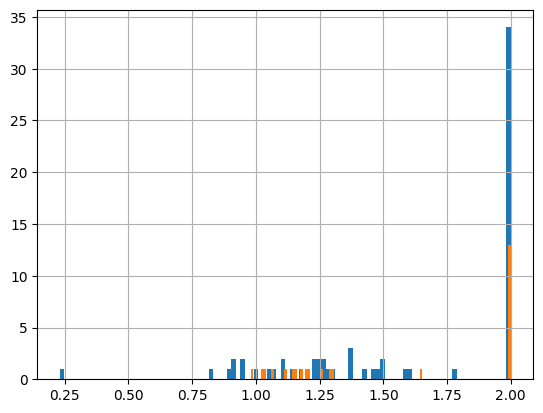

In [84]:
pd.Series([df_rates['ztfg_fade_hwhm']* 2 / df_rates['ztfg_fwhm']]).describe()
pd.Series([df_rates['ztfr_fade_hwhm']* 2 / df_rates['ztfr_fwhm']]).hist(bins=100)
pd.Series([df_rates['ztfi_fade_hwhm']* 2 / df_rates['ztfi_fwhm']]).hist(bins=100)

In [115]:
display(df_rates[df_rates['ztfg_rise_hwhm'].isnull()]['ztfg_fwhm'].describe())
display(df_rates[df_rates['ztfg_rise_hwhm'].notnull()]['ztfg_fwhm'].describe())

count    34.000000
mean      3.697956
std       3.050136
min       0.170266
25%       1.488125
50%       2.650991
75%       5.659379
max      11.437493
Name: ztfg_fwhm, dtype: float64

count    34.000000
mean      9.885935
std       8.202278
min       0.989092
25%       3.123890
50%       7.246548
75%      12.523363
max      29.567084
Name: ztfg_fwhm, dtype: float64

,obj_id,type,redshift,ztfg_fwhm_ratio,ztfr_fwhm_ratio,ztfi_fwhm_ratio
0,ZTF18aakuewf,Ibn,0.063600,1.225131,1.247312,NaN
1,ZTF18aalrxas,IIb,0.058200,1.139785,1.377778,NaN
2,ZTF18abffyqp,II,0.031000,1.712121,1.497487,NaN
3,ZTF18abvkmgw,Ib,0.038470,1.384428,1.369738,NaN
4,ZTF18abwkrbl,IIb,0.009990,1.421053,1.425743,NaN
...,...,...,...,...,...,...
64,ZTF23abnpdod,Cataclysmic,0.000000,1.333333,1.267606,1.300000
65,ZTF23abobwsd,IIb,0.024000,NaN,NaN,NaN
66,ZTF23absbqun,Ib,0.010100,1.121622,1.278552,NaN
67,ZTF23abtycgb,II,0.020127,NaN,NaN,NaN


,redshift,ztfg_fwhm_ratio,ztfr_fwhm_ratio,ztfi_fwhm_ratio
count,69.000000,34.000000,33.000000,14.000000
mean,0.154106,1.139296,1.206970,1.187104
std,0.435206,0.339324,0.290816,0.165355
min,-0.001000,0.206642,0.231156,0.979079
25%,0.001000,1.004998,1.062366,1.078249
50%,0.026728,1.141321,1.246377,1.169391
75%,0.054690,1.371655,1.377778,1.249694
max,2.900000,1.761194,1.780564,1.645161


<Axes: >

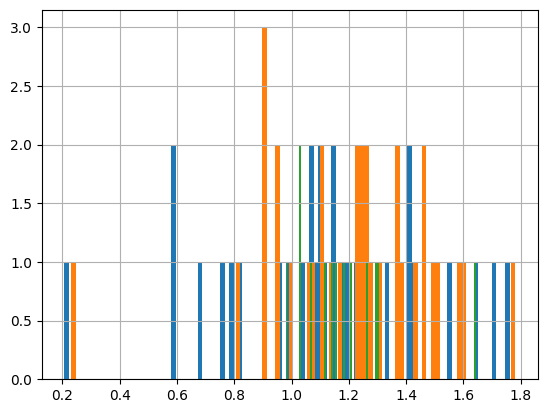

In [100]:
df_compare = pd.DataFrame()
df_compare['obj_id'] = df_rates['obj_id']
df_compare['type'] = df_rates['type']
df_compare['redshift'] = df_rates['redshift']
df_compare['ztfg_fwhm_ratio'] = (df_rates['ztfg_fade_hwhm']* 2) / df_rates['ztfg_fwhm']
df_compare['ztfr_fwhm_ratio'] = (df_rates['ztfr_fade_hwhm']* 2) / df_rates['ztfr_fwhm']
df_compare['ztfi_fwhm_ratio'] = (df_rates['ztfi_fade_hwhm']* 2 )/ df_rates['ztfi_fwhm']
df_compare.loc[df_compare['ztfg_fwhm_ratio'] == 2, 'ztfg_fwhm_ratio'] = np.nan
df_compare.loc[df_compare['ztfr_fwhm_ratio'] == 2, 'ztfr_fwhm_ratio'] = np.nan
df_compare.loc[df_compare['ztfi_fwhm_ratio'] == 2, 'ztfi_fwhm_ratio'] = np.nan

display(df_compare)
display(df_compare.describe())

df_compare['ztfg_fwhm_ratio'].hist(bins=100)
df_compare['ztfr_fwhm_ratio'].hist(bins=100)
df_compare['ztfi_fwhm_ratio'].hist(bins=100)

In [74]:
# df_rates.to_csv('gp_objects_rates.csv', index=False)